In [20]:
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
drive.mount('/content/drive')

In [7]:
import pandas as pd
ratings = pd.read_csv('MIR-Phase3-2/ratings.csv', sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

movies = pd.read_csv('MIR-Phase3-2/movies.csv', sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [22]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [23]:
ratings.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


### Content Based

**Objective**: Build a Content-Based Recommendation system that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

**Dataset**:
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Split the `genres` column into separate genre strings.
   - Fill any missing values in the `genres` column and convert it to string.

2. **Compute TF-IDF Matrix**:
   - Use `TfidfVectorizer` to transform the genres into a TF-IDF matrix.

3. **Calculate Cosine Similarity**:
   - Compute cosine similarity between the TF-IDF matrices of movies.

4. **Recommend Movies**:
   - Create a function that gets movie recommendations based on the cosine similarity score of movie genres.

In [24]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [25]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2), min_df = 0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'].values)

In [26]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [27]:
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def genre_recommendations(title, n=10):
    idx = indices[title]
    scores = list(enumerate(cosine_sim[idx]))
    top_recommendations = sorted(scores, key=lambda x: x[1], reverse=True)[1:n+1]
    return movies['title'].iloc[[i[0] for i in top_recommendations]]

In [28]:
# Example
genre_recommendations('GoldenEye (1995)')

345     Clear and Present Danger (1994)
543           Surviving the Game (1994)
724                    Rock, The (1996)
788                     Daylight (1996)
825               Chain Reaction (1996)
978                 Maximum Risk (1996)
1467                    Anaconda (1997)
1513                     Con Air (1997)
1693                   Firestorm (1998)
3686          Perfect Storm, The (2000)
Name: title, dtype: object


### Collaborative Filtering

**Objective**: Implement a collaborative filtering movie recommendation system to recommend movies to a user based on similar users' spreferences.

**Dataset**:

- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Split `genres` column into separate rows.

2. **Create User-Genre Matrix**:
   - Create a matrix where rows are users and columns are genres.
   - Each cell represents the ratio of movies watched by the user in that genre to the total movies watched by the user.

3. **Calculate User Similarity**:
   - Use cosine similarity to calculate the similarity between users.

4. **Find Top N Similar Users**:
   - Find the top N users with the most similar preferences to the given user.

5. **Recommend Movies**:
   - Recommend movies that similar users have watched but the target user has not.
   - Return titles and genres of the top 10 recommended movies.

In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
data = pd.merge(ratings, movies, on='movie_id')

In [32]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),Drama


In [33]:
data = data.assign(genres=data['genres'].str.split('|')).explode('genres')

In [34]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),Drama


In [43]:
user_genre = data.pivot_table(index='user_id', columns='genres', aggfunc='size', fill_value=0)
user_genre_matrix = user_genre.div(user_genre.sum(axis=1), axis=0)
user_genre_matrix.head()

genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
1,0.043103,0.043103,0.155172,0.172414,0.120690,0.017241,0.000000,0.181034,0.025862,0.000000,0.000000,0.120690,0.000000,0.051724,0.025862,0.025862,0.017241,0.000000
2,0.194444,0.065972,0.000000,0.000000,0.086806,0.041667,0.000000,0.274306,0.003472,0.003472,0.006944,0.000000,0.010417,0.083333,0.059028,0.107639,0.052083,0.010417
3,0.186992,0.203252,0.024390,0.024390,0.243902,0.000000,0.000000,0.065041,0.016260,0.000000,0.024390,0.008130,0.008130,0.040650,0.048780,0.040650,0.016260,0.048780
4,0.327586,0.103448,0.000000,0.017241,0.000000,0.017241,0.000000,0.103448,0.034483,0.000000,0.051724,0.000000,0.000000,0.034483,0.155172,0.068966,0.051724,0.034483
5,0.088068,0.025568,0.011364,0.017045,0.159091,0.059659,0.017045,0.295455,0.000000,0.008523,0.028409,0.008523,0.022727,0.085227,0.042614,0.110795,0.017045,0.002841


In [44]:
user_similarities = cosine_similarity(user_genre_matrix)
print(user_similarities)

[[1.         0.59392652 0.52642667 ... 0.69834932 0.78068502 0.68939203]
 [0.59392652 1.         0.66903366 ... 0.70715636 0.56343175 0.90698096]
 [0.52642667 0.66903366 1.         ... 0.68705058 0.6779119  0.62134421]
 ...
 [0.69834932 0.70715636 0.68705058 ... 1.         0.81983412 0.86195747]
 [0.78068502 0.56343175 0.6779119  ... 0.81983412 1.         0.71068362]
 [0.68939203 0.90698096 0.62134421 ... 0.86195747 0.71068362 1.        ]]


In [45]:
user_similarity_df = pd.DataFrame(user_similarities, index=user_genre_matrix.index, columns=user_genre_matrix.index)
user_similarity_df.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.593927,0.526427,0.345999,0.683741,0.804139,0.334192,0.634097,0.706181,0.789703,...,0.773599,0.819834,0.407116,0.187620,0.686592,0.721569,0.630877,0.698349,0.780685,0.689392
2,0.593927,1.000000,0.669034,0.770171,0.926928,0.644824,0.800366,0.951974,0.939869,0.763845,...,0.893203,0.772733,0.840031,0.309405,0.845356,0.916011,0.897834,0.707156,0.563432,0.906981
3,0.526427,0.669034,1.000000,0.665649,0.614157,0.672985,0.678774,0.484249,0.620163,0.862466,...,0.806012,0.724738,0.738403,0.176257,0.801695,0.724560,0.604351,0.687051,0.677912,0.621344
4,0.345999,0.770171,0.665649,1.000000,0.527271,0.376672,0.947039,0.584498,0.572512,0.579480,...,0.668976,0.454955,0.974503,0.165156,0.625503,0.636699,0.561714,0.337779,0.280647,0.510784
5,0.683741,0.926928,0.614157,0.527271,1.000000,0.723022,0.581497,0.949545,0.982931,0.817454,...,0.908946,0.888982,0.619386,0.369649,0.894214,0.963219,0.958866,0.828438,0.699646,0.985915


In [46]:
def get_top_n_similar_users(user_id, n=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index.tolist()
    similar_users.remove(user_id)
    return similar_users[:n]

In [47]:
def recommend_movies(user_id, n_similar_users=5, n_recommendations=10):
    similar_users = get_top_n_similar_users(user_id, n=n_similar_users)
    
    similar_users_data = data[data['user_id'].isin(similar_users)]
    
    watched_movies = data[data['user_id'] == user_id]['movie_id'].tolist()
    
    recommended_movies = similar_users_data[~similar_users_data['movie_id'].isin(watched_movies)]
    
    top_n = recommended_movies['movie_id'].value_counts().index[:n_recommendations]
    
    recommended_movies_info = movies[movies['movie_id'].isin(top_n)]
    return recommended_movies_info[['title', 'genres']]

In [48]:
# Example
user_id = 1
recommended_movies = recommend_movies(user_id, n_similar_users=5, n_recommendations=10)

In [49]:
recommended_movies

,title,genres
33,Babe (1995),Children's|Comedy|Drama
900,Casablanca (1942),Drama|Romance|War
1019,Alice in Wonderland (1951),Animation|Children's|Musical
1262,Fantasia (1940),Animation|Children's|Musical
1575,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
2009,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical
2011,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
2012,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
2018,Peter Pan (1953),Animation|Children's|Fantasy|Musical
2027,Sleeping Beauty (1959),Animation|Children's|Musical


### SVD (Singular Value Decomposition)



**Objective**: Implement an SVD-based recommendation system to recommend movies to users by decomposing the user-item interaction matrix into latent factors.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Create a user-item matrix where rows represent users, columns represent movies, and the values are the ratings.

2. **Decompose Matrix using SVD**:
   - Apply Singular Value Decomposition (SVD) to decompose the user-item matrix into three matrices: $U$, $\Sigma$, and $V^T$.

3. **Reconstruct Matrix**:
   - Reconstruct the user-item matrix using the top $k$ singular values to reduce dimensionality.

4. **Predict Ratings**:
   - Use the reconstructed matrix to predict ratings for all user-item pairs.

5. **Recommend Movies**:
   - Recommend the top 20 movies with the highest predicted ratings for a given user that the user hasn't rated yet.

In [51]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Fill na elements.

In [52]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# calculate rating matrix
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [54]:
U, sigma, Vt = svds(Ratings.values, k=500)
sigma = np.diag(sigma)

In [55]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [56]:
preds = pd.DataFrame(predicted_ratings, columns=Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.703333,0.267993,0.227068,0.208574,0.037784,0.211116,-0.071606,-0.089384,0.058296,-0.115528,...,0.036989,-0.030513,0.055480,-0.047841,-0.078905,-0.134897,-0.183411,0.051382,0.063540,0.219349
1,0.186605,-0.384384,0.263561,0.034374,0.244452,-0.113141,0.507855,-0.033870,0.130609,0.877592,...,-0.161415,-0.021699,-0.067089,0.016551,0.006890,-0.335264,-0.349321,-0.043556,-0.030103,0.181778
2,0.370330,0.471853,-0.029554,-0.146391,0.051400,-0.307491,0.244216,-0.060167,0.036427,0.852683,...,0.044072,0.029998,0.040082,0.004715,0.012745,-0.000820,0.204246,0.027996,-0.025839,-0.114927
3,-0.075659,0.114871,-0.080775,-0.050693,0.110614,-0.145656,0.019077,-0.010003,-0.030688,0.045586,...,-0.106984,0.030928,0.034485,-0.075781,-0.034201,-0.036467,0.028688,0.066144,0.027799,-0.072166
4,-0.311929,-0.393238,-0.149400,0.122275,-0.001939,1.964403,0.213568,0.022500,-0.022823,-0.138586,...,0.152565,0.046595,-0.114327,-0.062214,-0.127743,0.435600,0.236111,0.083376,-0.178232,-0.516045


In [57]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    index = userID - 1 
    sorted_preds = preds.iloc[index].sort_values(ascending=False)

    data = original_ratings[original_ratings.user_id == (userID)]

    user_full = (data.merge(movies, how='left', left_on='movie_id', right_on='movie_id').
                     sort_values(['rating'], ascending=False))

    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')

    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_preds).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {index: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )
    return user_full, recommendations

In [58]:
already_rated, predictions = recommend_movies(preds, 4375, movies, ratings, 20)

User 4375 has already rated 325 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [59]:
ratings.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
5,1,1197,3,0,1196
6,1,1287,5,0,1286
7,1,2804,5,0,2803
8,1,594,4,0,593
9,1,919,4,0,918


In [60]:
# Top 20 movies that User 4375 has rated
already_rated.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
195,4375,3250,5,4374,3249,Alive (1993),Drama
285,4375,175,5,4374,174,Kids (1995),Drama
199,4375,3257,5,4374,3256,"Bodyguard, The (1992)",Action|Drama|Romance|Thriller
65,4375,3809,5,4374,3808,What About Bob? (1991),Comedy
210,4375,2688,5,4374,2687,"General's Daughter, The (1999)",Drama|Thriller
270,4375,150,5,4374,149,Apollo 13 (1995),Drama
271,4375,2710,5,4374,2709,"Blair Witch Project, The (1999)",Horror
125,4375,349,5,4374,348,Clear and Present Danger (1994),Action|Adventure|Thriller
60,4375,288,5,4374,287,Natural Born Killers (1994),Action|Thriller
141,4375,47,5,4374,46,Seven (Se7en) (1995),Crime|Thriller


#### Evaluation

In [61]:
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

train_ratings = train_data.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
R_train = train_ratings.values

train_mean = np.mean(R_train, axis=1)
train_ratings_demeaned = R_train - train_mean.reshape(-1, 1)

U_train, sigma_train, Vt_train = svds(train_ratings_demeaned, k=500)
sigma_train = np.diag(sigma_train)

all_predicted_ratings = np.dot(np.dot(U_train, sigma_train), Vt_train) + train_mean.reshape(-1, 1)
preds_train = pd.DataFrame(all_predicted_ratings, columns=train_ratings.columns)

def predict_rating(user_id, movie_id):
    try:
        pred = preds_train.loc[user_id - 1, movie_id]
    except KeyError:
        pred = train_mean.mean()
    return pred

test_data['predicted_rating'] = test_data.apply(lambda x: predict_rating(x['user_id'], x['movie_id']), axis=1)

test_data.dropna(inplace=True)

rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 3.4827105687589412


### Nueral Network Model (Recommender Model)



**Objective**: Implement a Recommender model to recommend movies to a user based on similar users' preferences.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Define Dataset and DataLoader**:
   - Create a custom PyTorch `Dataset` for ratings.
   - Create a DataLoader for batching and shuffling data.

2. **Define the Neural Network**:
   - Create a neural network with embedding layers for users and movies.

3. **Train the Model**:
   - Train the model using Mean Squared Error loss and Adam optimizer.
   - Save model checkpoints.

4. **Evaluate the Model**:
   - Calculate RMSE on the entire dataset.

5. **Predict Ratings for Unrated Movies**:
   - Predict and recommend top 10 unrated movies for a given user.

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import zip_longest
import math
from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:
# Define the dataset
class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.ratings = ratings
        self.user_id = ratings['user_id'].values
        self.movie_id = ratings['movie_id'].values
        self.rating = ratings['rating'].values
    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return torch.tensor(self.user_id[idx], dtype=torch.long), torch.tensor(self.movie_id[idx], dtype=torch.long),torch.tensor(self.rating[idx], dtype=torch.float)

# Define the neural network
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50, embedding_dropout=0.02):
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(embedding_dropout)
        self.relu = nn.ReLU()

    def forward(self, user, movie):
        user_emb = self.user_embedding(user)
        movie_emb = self.movie_embedding(movie)
        x = torch.cat([user_emb, movie_emb], dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Create the dataset and dataloader
dataset = RatingsDataset(ratings)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize the model, loss function and optimizer
n_users = ratings['user_id'].nunique()
n_movies = ratings['movie_id'].nunique()

model = RecommenderNet(n_users + 300, n_movies + 300)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for user, movie, rating in dataloader:
        optimizer.zero_grad()
        outputs = model(user, movie)
        loss = criterion(outputs.squeeze(), rating)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}')

Epoch 1/10, Loss: 0.9646849220915241
Epoch 2/10, Loss: 0.8484236948533924
Epoch 3/10, Loss: 0.8307361427294834
Epoch 4/10, Loss: 0.8173739387245521
Epoch 5/10, Loss: 0.8054326496538285
Epoch 6/10, Loss: 0.7937888942987358
Epoch 7/10, Loss: 0.7810031376882527
Epoch 8/10, Loss: 0.7669227354924978
Epoch 9/10, Loss: 0.7524902365915346
Epoch 10/10, Loss: 0.7393400630407702


In [4]:
# Evaluation
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for user, movie, rating in dataloader:
        outputs = model(user, movie)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(rating.tolist())
    rmse = math.sqrt(mean_squared_error(actuals, predictions))
    print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.846284832700164


In [5]:
# Example
sample_user_id = 1
sample_user_data = ratings[ratings['user_id'] == sample_user_id]
sample_dataset = RatingsDataset(sample_user_data)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(f'Sample predictions for user ID {sample_user_id}:')
with torch.no_grad():
    for user, movie, rating in sample_dataloader:
        output = model(user, movie).squeeze()
        print(f'Movie ID: {movie.item()}, Predicted Rating: {output.item()}, Actual Rating: {rating.item()}')

Sample predictions for user ID 1:
Movie ID: 1193, Predicted Rating: 4.409586429595947, Actual Rating: 5.0
Movie ID: 661, Predicted Rating: 3.7335760593414307, Actual Rating: 3.0
Movie ID: 914, Predicted Rating: 3.7749176025390625, Actual Rating: 3.0
Movie ID: 3408, Predicted Rating: 3.6720824241638184, Actual Rating: 4.0
Movie ID: 2355, Predicted Rating: 4.0961012840271, Actual Rating: 5.0
Movie ID: 1197, Predicted Rating: 4.005803108215332, Actual Rating: 3.0
Movie ID: 1287, Predicted Rating: 4.128786563873291, Actual Rating: 5.0
Movie ID: 2804, Predicted Rating: 3.9934568405151367, Actual Rating: 5.0
Movie ID: 594, Predicted Rating: 4.054996490478516, Actual Rating: 4.0
Movie ID: 919, Predicted Rating: 4.264439582824707, Actual Rating: 4.0
Movie ID: 595, Predicted Rating: 4.137448787689209, Actual Rating: 5.0
Movie ID: 938, Predicted Rating: 3.7180871963500977, Actual Rating: 4.0
Movie ID: 2398, Predicted Rating: 3.881277084350586, Actual Rating: 4.0
Movie ID: 2918, Predicted Rating:

In [6]:
def predict_unrated_movies(user_id, model, ratings, movies, n=10):
    model.eval()
    user_tensor = torch.tensor([user_id], dtype=torch.long)
    movie_ids = movies['movie_id'].values
    movie_tensor = torch.tensor(movie_ids, dtype=torch.long)

    with torch.no_grad():
        predictions = model(user_tensor.repeat(len(movie_ids)), movie_tensor).squeeze().numpy()
    
    # unrated movies
    rated_movies = ratings[ratings['user_id'] == user_id]['movie_id'].values
    unrated_movies = movies[~movies['movie_id'].isin(rated_movies)]
    unrated_movies['predicted_rating'] = predictions[~np.isin(movie_ids, rated_movies)]

    # top n
    recommendations = unrated_movies.sort_values(by='predicted_rating', ascending=False).head(n)
    return recommendations[['title', 'genres', 'predicted_rating']]


# Example
user_id = 1
predictions = predict_unrated_movies(user_id, model, ratings, movies)
print(predictions)

                                                  title            genres  \
3366                            Double Indemnity (1944)   Crime|Film-Noir   
643                  Cold Fever (Á köldum klaka) (1994)      Comedy|Drama   
1950  Seven Samurai (The Magnificent Seven) (Shichin...      Action|Drama   
892                                  Rear Window (1954)  Mystery|Thriller   
740   Dr. Strangelove or: How I Learned to Stop Worr...        Sci-Fi|War   
2868                       Palm Beach Story, The (1942)            Comedy   
1080                             Sophie's Choice (1982)             Drama   
1340  Paradise Lost: The Child Murders at Robin Hood...       Documentary   
52                                      Lamerica (1994)             Drama   
911                                 Citizen Kane (1941)             Drama   

      predicted_rating  
3366          5.011544  
643           4.896519  
1950          4.887469  
892           4.865328  
740           4.865120  
28

/var/folders/09/231t9s654db24dw3fmq2bn4w0000gn/T/ipykernel_81040/2260552312.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unrated_movies['predicted_rating'] = predictions[~np.isin(movie_ids, rated_movies)]


### GMM (Gaussian Mixture Model)

**Objective**: Use a Gaussian Mixture Model to analyze and cluster the click data based on the number of clicks from different locations, aiming to identify distinct patterns of user behavior across 10 countries.

**Dataset**:
- **Click Data**: DataFrame with columns `link_id`, `location`, and `number_of_clicks`.

**Steps**:

1. **Preprocess Data**:
   - Ensure the dataset contains 10 distinct countries.
   - Create a matrix where rows represent different links and columns represent the number of clicks from each country.
   - Normalize the number of clicks to account for different scales.

2. **Fit GMM**:
   - Apply a Gaussian Mixture Model (GMM) to the click data matrix to identify clusters of links with similar click patterns across different countries.

3. **Evaluate Model**:
   - Analyze the resulting model by calculating the log lokelihood, BIC and AIC metrics.


In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

file_path ='MIR-Phase3-2/gmm-dataset.csv'
df = pd.read_csv(file_path)
df.head()

,URL,United States,China,India,Japan,Brazil,Russia,Indonesia,Germany,United Kingdom,France
0,url_1,657,194,310,790,768,436,189,973,448,335
1,url_2,389,149,354,729,629,937,345,967,764,104
2,url_3,979,475,509,769,270,705,113,931,977,213
3,url_4,524,699,692,694,473,160,484,37,956,899
4,url_5,767,661,319,572,399,401,277,596,631,203


In [2]:
if len(df.columns) == 10:
    print("dataset has 10 distinct countries!")

click_matrix = df.drop(columns='URL').values

scaler = StandardScaler()
normalized_click_matrix = scaler.fit_transform(click_matrix)

In [3]:
gmm = GaussianMixture(n_components=11, random_state=42)
gmm.fit(normalized_click_matrix)
labels = gmm.predict(normalized_click_matrix)
print(labels)

[ 2  2  2  1  4  3  0  9  6  3 10  5  5  2  9  0 10  4  7  9  3  1  5  6
  5  1  3 10 10  4  3  0  1  0  1  0  7  0  0  6  4  9  2  6  2  8  5  5
  0  1  5  2  6 10  2  9  6  0  7  0  8  1  5  9  9  3  8  8  8  1  1  7
  8  4  6  8  5  0  8  7  1  3  6  9  4  6  1  3  0  0  0  0  8  9  9  9
  9  4  0  8]


In [4]:
log_likelihood = gmm.score(normalized_click_matrix)
bic = gmm.bic(normalized_click_matrix)
aic = gmm.aic(normalized_click_matrix)

print(f"Log-Likelihood: {log_likelihood}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")

Log-Likelihood: 1.5895426087872753
BIC: 3020.8398630839115
AIC: 1132.091478242545


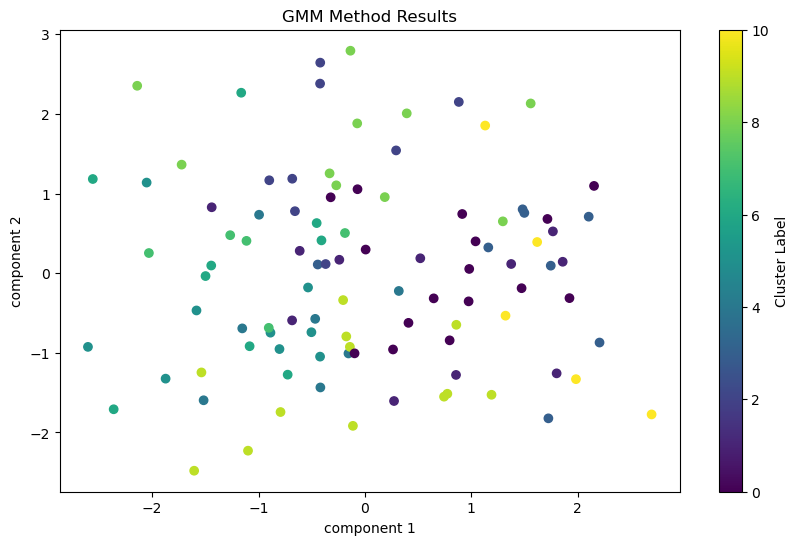

In [5]:
pca = PCA(n_components=2)
clicks = pca.fit_transform(normalized_click_matrix)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(clicks[:, 0], clicks[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('GMM Method Results')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()